In [1]:
!pip install timm

In [2]:
import os
from tqdm import tqdm
import pickle
import argparse
import time
import torch
import yaml
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from IPython.display import display

from utils import set_seed, load_model, save, get_model, update_optimizer, get_data
from epoch import train_epoch, val_epoch, test_epoch
from cli import add_all_parsers
import greenstand_utils as gu  # GREENSTAND


def get_args(hyperparameter_config_file='hyperparameters.yaml'):
    with open(hyperparameter_config_file) as file:
        contents = yaml.safe_load(file)
    new_args = []
    for item in contents:
        new_args.append('--' + item)
        new_args.append(str(contents[item]))
    return new_args


def train(args):
    set_seed(args, use_gpu=torch.cuda.is_available())
    
    # Get Data  # GREENSTAND
    g_args = vars(args) # GREENSTAND
    g_args['prefixes'] = g_args['prefixes'].split(',') # GREENSTAND
    train_loader, val_loader, test_loader, dataset_attributes = gu.sync_split_get_dataloaders(vars(args))  # GREENSTAND
    print(f"Dataset Attributes: {dataset_attributes}") # GREENSTANDS

    model = gu.load_preloaded_model(args, dataset_attributes)  # GREENSTAND - Get pretrained model if specified 
    criteria = CrossEntropyLoss() 

    if args.use_gpu:
        torch.cuda.set_device(0)
        model.cuda()
        criteria.cuda()

    optimizer = SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.mu, nesterov=True)

    # Containers for storing metrics over epochs
    loss_train, acc_train, topk_acc_train = [], [], []
    loss_val, acc_val, topk_acc_val, avgk_acc_val, class_acc_val = [], [], [], [], []

    save_name = args.save_name_xp.strip()
    save_dir = os.path.join(os.getcwd(), 'results', save_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print('args.k : ', args.k)

    lmbda_best_acc = None
    best_val_acc = float('-inf')

    for epoch in tqdm(range(args.n_epochs), desc='epoch', position=0):
        t = time.time()
        optimizer = update_optimizer(optimizer, lr_schedule=dataset_attributes['lr_schedule'], epoch=epoch)

        loss_epoch_train, acc_epoch_train, topk_acc_epoch_train = train_epoch(model, optimizer, train_loader,
                                                                              criteria, loss_train, acc_train,
                                                                              topk_acc_train, args.k,
                                                                              dataset_attributes['n_train'],
                                                                              args.use_gpu)

        loss_epoch_val, acc_epoch_val, topk_acc_epoch_val, \
        avgk_acc_epoch_val, lmbda_val = val_epoch(model, val_loader, criteria,
                                                  loss_val, acc_val, topk_acc_val, avgk_acc_val,
                                                  class_acc_val, args.k, dataset_attributes, args.use_gpu)

        # save model at every epoch
        save(model, optimizer, epoch, os.path.join(save_dir, save_name + '_weights.tar'))

        # save model with best val accuracy
        if acc_epoch_val > best_val_acc:
            best_val_acc = acc_epoch_val
            lmbda_best_acc = lmbda_val
            save(model, optimizer, epoch, os.path.join(save_dir, save_name + '_weights_best_acc.tar'))

        print()
        print(f'epoch {epoch} took {time.time()-t:.2f}')
        print(f'loss_train : {loss_epoch_train}')
        print(f'loss_val : {loss_epoch_val}')
        print(f'acc_train : {acc_epoch_train} / topk_acc_train : {topk_acc_epoch_train}')
        print(f'acc_val : {acc_epoch_val} / topk_acc_val : {topk_acc_epoch_val} / '
              f'avgk_acc_val : {avgk_acc_epoch_val}')

    # load weights corresponding to best val accuracy and evaluate on test
    load_model(model, os.path.join(save_dir, save_name + '_weights_best_acc.tar'), args.use_gpu)
    loss_test_ba, acc_test_ba, topk_acc_test_ba, \
    avgk_acc_test_ba, class_acc_test, confuse = test_epoch(model, test_loader, criteria, args.k,
                                                  lmbda_best_acc, args.use_gpu,
                                                  dataset_attributes)
    
    print("Average test accuracy: {}".format(avgk_acc_test_ba))
    print("Average class accuracies: {}".format(class_acc_test))
    display(confuse)

    # Save the results as a dictionary and save it as a pickle file in desired location

    results = {'loss_train': loss_train, 'acc_train': acc_train, 'topk_acc_train': topk_acc_train,
               'loss_val': loss_val, 'acc_val': acc_val, 'topk_acc_val': topk_acc_val, 'class_acc_val': class_acc_val,
               'avgk_acc_val': avgk_acc_val,
               'test_results': {'loss': loss_test_ba,
                                'accuracy': acc_test_ba,
                                'topk_accuracy': topk_acc_test_ba,
                                'avgk_accuracy': avgk_acc_test_ba,
                                'class_acc_dict': class_acc_test},
               'params': args.__dict__}

    with open(os.path.join(save_dir, save_name + '.pkl'), 'wb') as f:
        pickle.dump(results, f)
        

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Use CUDA: True
Seed:	 1
Checking to make sure all local files are present...
Checking missing local files based on bucket: treetracker-training-images at prefix haiti/...
No missing items locally.
Checking missing local files based on bucket: treetracker-training-images at prefix herbarium/...
No missing items locally.
Creating metadata file with pre-determined train, val, test splits...
Loading datasets...
Will not include class PERSAMER due to not having enough data for train/val/test split...
Will not include class CUPRLUSI due to not having enough data for train/val/test split...
Writing metadata.json...
Creating data loaders...
Loading datasets...


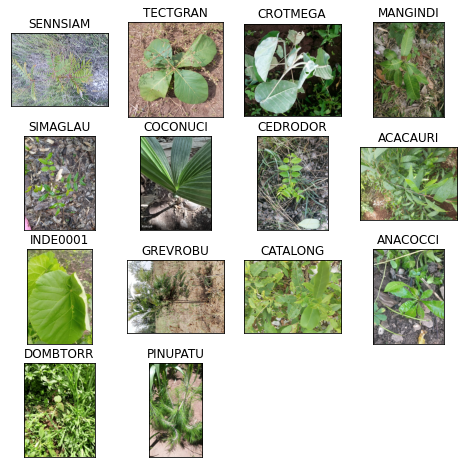

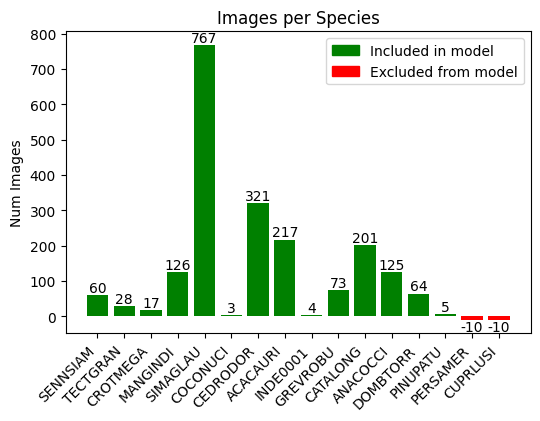

Dataset Attributes: {'n_train': 1278, 'n_val': 325, 'n_test': 408, 'n_classes': 14, 'lr_schedule': [40, 50, 60], 'class2num_instances': {'train': {0: 38, 1: 17, 2: 10, 3: 490, 4: 80, 5: 1, 6: 205, 7: 138, 8: 2, 9: 46, 10: 128, 11: 80, 12: 40, 13: 3}, 'val': {0: 10, 1: 5, 2: 3, 3: 123, 4: 20, 5: 1, 6: 51, 7: 35, 8: 1, 9: 12, 10: 32, 11: 20, 12: 11, 13: 1}, 'test': {0: 12, 1: 6, 2: 4, 3: 154, 4: 26, 5: 1, 6: 65, 7: 44, 8: 1, 9: 15, 10: 41, 11: 25, 12: 13, 13: 1}}, 'class_to_idx': {'SENNSIAM': 0, 'TECTGRAN': 1, 'CROTMEGA': 2, 'MANGINDI': 3, 'SIMAGLAU': 4, 'COCONUCI': 5, 'CEDRODOR': 6, 'ACACAURI': 7, 'INDE0001': 8, 'GREVROBU': 9, 'CATALONG': 10, 'ANACOCCI': 11, 'DOMBTORR': 12, 'PINUPATU': 13}, 'invalid_classes': ['PERSAMER', 'CUPRLUSI'], 'total_instances_per_class': {'SENNSIAM': 60, 'TECTGRAN': 28, 'CROTMEGA': 17, 'SIMAGLAU': 126, 'MANGINDI': 767, 'COCONUCI': 3, 'CEDRODOR': 321, 'ACACAURI': 217, 'INDE0001': 4, 'GREVROBU': 73, 'CATALONG': 201, 'ANACOCCI': 125, 'DOMBTORR': 64, 'PINUPATU': 5}

train:   0%|          | 0/80 [00:00<?, ?it/s]

[2022-08-12 21:11:51.307 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:4887 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2022-08-12 21:11:51.443 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:4887 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


val:   0%|          | 0/21 [00:00<?, ?it/s]/root/greenstand-planetnet-baseline-p-gv8eryhwlca8/sagemaker-greenstand-planetnet-baseline-p-gv8eryhwlca8-modelbuild/greenstand/epoch.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_proba = F.softmax(batch_output_val)
epoch:  10%|█         | 1/10 [00:19<02:51, 19.02s/it]


epoch 0 took 19.02
loss_train : 0.9090134343014488
loss_val : 0.7296037007123232
acc_train : 0.7331768388106417 / topk_acc_train : {1: 0.7331768388106417}
acc_val : 0.8676923076923077 / topk_acc_val : {1: 0.8676923076923077} / avgk_acc_val : {1: 0.8738461538461538}


epoch:  20%|██        | 2/10 [00:35<02:18, 17.32s/it]


epoch 1 took 16.12
loss_train : 0.43923996011667615
loss_val : 0.7021086141467094
acc_train : 0.865414710485133 / topk_acc_train : {1: 0.865414710485133}
acc_val : 0.8276923076923077 / topk_acc_val : {1: 0.8276923076923077} / avgk_acc_val : {1: 0.8369230769230769}


epoch:  30%|███       | 3/10 [00:51<01:58, 16.91s/it]


epoch 2 took 16.42
loss_train : 0.3295237577602833
loss_val : 0.6656467370688915
acc_train : 0.8841940532081377 / topk_acc_train : {1: 0.8841940532081377}
acc_val : 0.8492307692307692 / topk_acc_val : {1: 0.8492307692307692} / avgk_acc_val : {1: 0.8646153846153846}


epoch:  40%|████      | 4/10 [01:07<01:39, 16.58s/it]


epoch 3 took 16.08
loss_train : 0.3468369400906789
loss_val : 0.77910943813622
acc_train : 0.8849765258215962 / topk_acc_train : {1: 0.8849765258215962}
acc_val : 0.8553846153846154 / topk_acc_val : {1: 0.8553846153846154} / avgk_acc_val : {1: 0.8492307692307692}


epoch:  50%|█████     | 5/10 [01:23<01:22, 16.40s/it]


epoch 4 took 16.09
loss_train : 0.2441305618591701
loss_val : 1.1003637999296187
acc_train : 0.9194053208137715 / topk_acc_train : {1: 0.9194053208137715}
acc_val : 0.8553846153846154 / topk_acc_val : {1: 0.8553846153846154} / avgk_acc_val : {1: 0.8553846153846154}


epoch:  60%|██████    | 6/10 [01:40<01:06, 16.54s/it]


epoch 5 took 16.79
loss_train : 0.23133875549876992
loss_val : 0.7532739682123065
acc_train : 0.9233176838810642 / topk_acc_train : {1: 0.9233176838810642}
acc_val : 0.88 / topk_acc_val : {1: 0.88} / avgk_acc_val : {1: 0.8769230769230769}


epoch:  70%|███████   | 7/10 [01:56<00:49, 16.35s/it]


epoch 6 took 15.97
loss_train : 0.16576172871208644
loss_val : 1.1998337233439087
acc_train : 0.9483568075117371 / topk_acc_train : {1: 0.9483568075117371}
acc_val : 0.8523076923076923 / topk_acc_val : {1: 0.8523076923076923} / avgk_acc_val : {1: 0.8553846153846154}


epoch:  80%|████████  | 8/10 [02:12<00:32, 16.36s/it]


epoch 7 took 16.39
loss_train : 0.1569882843973516
loss_val : 1.3610208790749312
acc_train : 0.9491392801251957 / topk_acc_train : {1: 0.9491392801251957}
acc_val : 0.8492307692307692 / topk_acc_val : {1: 0.8492307692307692} / avgk_acc_val : {1: 0.8492307692307692}


epoch:  90%|█████████ | 9/10 [02:28<00:16, 16.14s/it]


epoch 8 took 15.64
loss_train : 0.13145547151518397
loss_val : 1.1967922342941164
acc_train : 0.960093896713615 / topk_acc_train : {1: 0.960093896713615}
acc_val : 0.8615384615384616 / topk_acc_val : {1: 0.8615384615384616} / avgk_acc_val : {1: 0.8615384615384616}


epoch: 100%|██████████| 10/10 [02:44<00:00, 16.45s/it]


epoch 9 took 15.98
loss_train : 0.10308513858744615
loss_val : 2.0608939465135334
acc_train : 0.9694835680751174 / topk_acc_train : {1: 0.9694835680751174}
acc_val : 0.8492307692307692 / topk_acc_val : {1: 0.8492307692307692} / avgk_acc_val : {1: 0.8492307692307692}


test:   0%|          | 0/26 [00:00<?, ?it/s]/root/greenstand-planetnet-baseline-p-gv8eryhwlca8/sagemaker-greenstand-planetnet-baseline-p-gv8eryhwlca8-modelbuild/greenstand/epoch.py:162: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  batch_proba_test = F.softmax(batch_output_test)
test: 100%|██████████| 26/26 [00:04<00:00,  6.31it/s]

Average test accuracy: {1: 0.8259803921568627}
Average class accuracies: {'class_acc': defaultdict(<class 'int'>, {7: 0.8181818181818182, 4: 0.5769230769230769, 11: 0.68, 3: 0.8831168831168831, 6: 0.8769230769230769, 9: 0.8666666666666667, 1: 1.0, 10: 0.8048780487804879, 0: 0.9166666666666666, 12: 0.7692307692307693, 13: 0.0, 5: 1.0, 2: 0.75, 8: 1.0}), 'class_topk_acc': {1: defaultdict(<class 'int'>, {7: 0.8181818181818182, 4: 0.5769230769230769, 11: 0.68, 3: 0.8831168831168831, 6: 0.8769230769230769, 9: 0.8666666666666667, 1: 1.0, 10: 0.8048780487804879, 0: 0.9166666666666666, 12: 0.7692307692307693, 13: 0.0, 5: 1.0, 2: 0.75, 8: 1.0})}, 'class_avgk_acc': {1: defaultdict(<class 'int'>, {7: 0.8409090909090909, 4: 0.5769230769230769, 11: 0.64, 3: 0.8766233766233766, 6: 0.8769230769230769, 9: 0.8666666666666667, 1: 1.0, 10: 0.8048780487804879, 0: 0.9166666666666666, 12: 0.7692307692307693, 13: 0.0, 5: 1.0, 2: 0.75, 8: 0.0})}}


tp  fp   tn  fn  num_instances  accuracy  precision    recall
SENNSIAM   11   2  394   1             12  0.916667   0.846154  0.916667
TECTGRAN    6   1  401   0              6  1.000000   0.857143  1.000000
CROTMEGA    3   0  404   1              4  0.750000   1.000000  0.750000
MANGINDI  136  20  234  18            154  0.883117   0.871795  0.883117
SIMAGLAU   15   4  378  11             26  0.576923   0.789474  0.576923
COCONUCI    1   1  406   0              1  1.000000   0.500000  1.000000
CEDRODOR   57  11  332   8             65  0.876923   0.838235  0.876923
ACACAURI   36   5  359   8             44  0.818182   0.878049  0.818182
INDE0001    1   0  407   0              1  1.000000   1.000000  1.000000
GREVROBU   13   2  391   2             15  0.866667   0.866667  0.866667
CATALONG   33  10  357   8             41  0.804878   0.767442  0.804878
ANACOCCI   17   3  380   8             25  0.680000   0.850000  0.680000
DOMBTORR   10   5  390   3             13  0.769231   0.666667  0.769231
PINUPATU    0   0  407   1              1  0.000000        NaN  0.000000

In [3]:
"""To run: python main.py --lr=0.05 --n_epochs=80 --k 1 3 5 10 --model=resnet50 --root=path_to_data --save_name_xp=xp1"""

"""
Provide your arguments here in this format:
[
 argname1, argvalue1,
 argname2, argvalue2
]
"""
print(f"Use CUDA: {torch.cuda.is_available()}")
arg_list = get_args()
parser = argparse.ArgumentParser()
add_all_parsers(parser)
args = parser.parse_args(args=arg_list)
train(args)